# Structure and Analyse Job Descriptions
Based on the [Kaggle competition](https://www.kaggle.com/c/data-science-for-good-city-of-los-angeles)
### Data Science for Good: City of Los Angeles
  
### Contents
* Introduction
* Preparing the data
* EDA
* Sentiment analysis



Importing necessary libraries

In [138]:
import numpy as np
import pandas as pd
import os
import re
import datetime

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
import cufflinks as cf
from nltk import word_tokenize


* File formats in the data
* csv
* pdf
* txt
* docx


 Goal: convert job postings into single structured csv file


Load sample .csv files

In [3]:
job_title_dict = pd.read_csv('CityofLA/Additional data/job_titles.csv',
                             header=None, names=['job_title'])

kaggle_data_dictionary = pd.read_csv('CityofLA/Additional data/kaggle_data_dictionary.csv')

sample_export = pd.read_csv('CityofLA/Additional data/sample job class export template.csv')


 Shape of sample export

In [6]:
sample_export.shape
# multiple rows for each job title
# number of rows given by required

(5, 25)

In [7]:
sample_export.keys()
sample_export

# The kaggle_data_dictionary file gives the column names
# as well as the data types for each column of the target data frame


,FILE_NAME,JOB_CLASS_TITLE,JOB_CLASS_NO,REQUIREMENT_SET_ID,REQUIREMENT_SUBSET_ID,JOB_DUTIES,EDUCATION_YEARS,SCHOOL_TYPE,EDUCATION_MAJOR,EXPERIENCE_LENGTH,...,COURSE_LENGTH,COURSE_SUBJECT,MISC_COURSE_DETAILS,DRIVERS_LICENSE_REQ,DRIV_LIC_TYPE,ADDTL_LIC,EXAM_TYPE,ENTRY_SALARY_GEN,ENTRY_SALARY_DWP,OPEN_DATE
0,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,1,A,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,COMPUTER SCIENCE|INFORMATION SYSTEMS|GEOGRAPHI...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
1,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,2,A,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
2,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,2,B,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
3,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,2,C,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
4,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,3,A,"A Systems Analyst analyzes procedures, methods...",NaN,NaN,NaN,2.0,...,"3M, 4Q",INFORMATION SYSTEMS|SYSTEMS ANALYSIS|closely r...,At least three of the courses must be from the...,M,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17


Describe target data frame


In [8]:
# Creating empty target data frame
print('The data types for the columns are:\n{}'.format(pd.unique(kaggle_data_dictionary['Data Type'])))
data_type_list = list()
for i in kaggle_data_dictionary['Data Type']:
    if i == 'String':
        data_type_list.append('object')
    elif i == 'Integer':
        data_type_list.append('int64')
    elif i == 'Float':
        data_type_list.append('float64')
    elif i == 'Date':
        data_type_list.append('object')
    else:
        print('dtype not found')

df_dtype = pd.DataFrame(kaggle_data_dictionary['Field Name'])
df_dtype['dtype'] = data_type_list

dtypes = {}
for i in range(len(df_dtype)):
    dtypes[df_dtype['Field Name'][i]] = np.dtype(df_dtype['dtype'][i])


The data types for the columns are:
['String' 'Integer' 'Float' 'Date']


In [9]:
df = pd.DataFrame(columns=kaggle_data_dictionary['Field Name'])
df = df.astype(dtype=dtypes)


Look for numbers and non-capital letters in job titles

In [10]:
for i in job_title_dict['job_title']:
    if re.match(r'([^A-Z])', i) is not None:
        print('Job title ' + i + ' contains numbers')




Job title 311 DIRECTOR contains numbers



* Folder job bullitins contains txt files of job postings

* vars for job bullitin
* job title
* class code
* open date
* revised date, if revised
* annual salary


Get variables 'FILE_NAME' and 'JOB_CLASS_TITLE'.
  
Adding a column with the full filepath.


In [11]:
jb_dir = 'CityofLA/Job Bulletins'

# get list of job openings

jb_files = os.listdir(jb_dir)

# Loading path to files

def get_file_path(files, folder_path):
    file_list = list()
    for filename in files:
        filepath = os.path.join(folder_path, filename)
        file_list.append(filepath)
    return file_list

jb_path_list = get_file_path(jb_files, jb_dir)
df_jb = df
df_jb['filepath'] = jb_path_list


Extracting job titles

In [98]:
jb_title = list()
for filepath in df_jb['filepath']:
    job_title = re.findall(r'\b[A-Z][A-Z]+\b', filepath)
    job_title = ' '.join(job_title)
    jb_title.append(job_title)


jb_title = [x.lower() for x in jb_title]
df_jb['FILE_NAME'] = jb_files




Clean job titles


In [101]:
# remove 'rev' from job title


def clean_jb_title():
    rm_rev = re.compile(r'\srev')
    for i, k in enumerate(jb_title):
        if re.search(rm_rev, k) is not None:
            jb_title[i] = re.sub(rm_rev, '', k)
    return jb_title

df_jb['JOB_CLASS_TITLE'] = clean_jb_title()


In [ ]:
# reverse removal of numbers in job title
df_jb['JOB_CLASS_TITLE'][0] = '311 director'


Extracting Class code


In [14]:


def get_var_class_code():
    class_code = list()
    # Selecting file
    for i in df_jb['filepath']:
        # Opening file
        open_file = open(i, 'r')
        read_file = open_file.readlines()
        # Reading the file line by line to search for class code
        for j in np.arange(len(read_file)):
            # Looking for the class code in the file
            if re.search(r'([Cc]lass\s[Cc]ode)', read_file[j]):
                if re.search(r'[0-9]{4}', read_file[j]):
                    class_code.extend(re.findall(r'[0-9]{4}', read_file[j]))
                    break
                elif re.search(r'[0-9]{4}', read_file[j+1]):
                    class_code.extend(re.findall(r'[0-9]{4}', read_file[j+1]))
                    break

        # check if a class code was appended and append 'None' if there was no class code in the file.
        if len(class_code) - 1 != df_jb.loc[df_jb['filepath'] == i].index:
            print('\nNo class code found for job title:')
            print(df_jb['JOB_CLASS_TITLE'].loc[df_jb['filepath'] == i].values)
            print('Index for file: {}'.format(df_jb.loc[df_jb['filepath'] == i].index))
            print('Appending \'0000\' for unkown class code.')
            class_code.append('0000')
        open_file.close()
    return class_code


In [15]:

class_code = get_var_class_code()
df_jb['JOB_CLASS_NO'] = class_code



No class code found for job title:
['department of public works']
Index for file: Int64Index([646], dtype='int64')
Appending '0000' for unkown class code.


In [16]:
# Function returns four variables 'class_code', 'open_date', 'rev_date' and 'rev_status'.
# I ended up not using this function, as 'rev_date' and 'rev_status' was not required at this point.


def get_vars():
    class_code = list()
    open_date = list()
    rev_date = list()
    rev_status = list()
    # Selecting file
    for i in df_jb['filepath']:
        # Opening file
        open_file = open(i, 'r')
        read_file = open_file.readlines()
        # Reading the file line by line to search for class code
        for j in np.arange(len(read_file)):
            # Looking for the class code in the file
            if re.search(r'([Cc]lass\s[Cc]ode)', read_file[j]):
                if re.search(r'[0-9]{4}', read_file[j]):
                    class_code.append(re.findall(r'[0-9]{4}', read_file[j]))
                    break
                elif re.search(r'[0-9]{4}', read_file[j+1]):
                    class_code.append(re.findall(r'[0-9]{4}', read_file[j+1]))
                    break

        # check if a class code was appended and append 'None' if there was no class code in the file.
        if len(class_code) - 1 != df_jb.loc[df_jb['filepath'] == i].index:
            print('\nNo class code found for job title:')
            print(df_jb['JOB_CLASS_TITLE'].loc[df_jb['filepath'] == i].values)
            print('Index for file: {}'.format(df_jb.loc[df_jb['filepath'] == i].index))
            print('Appending \'0000\' for unkown class code.')
            class_code.append(0000)

        # Using separate for-loop to look for 'open date'.
        for k in np.arange(len(read_file)):
            if re.search(r'([Oo]pen\s[Dd]ate)', read_file[k]):
                if re.search(r'(\d{1,2}-\d{1,2}-\d{1,2}).*', read_file[k]):
                    open_date.extend(re.findall(r'(\d{1,2}-\d{1,2}-\d{1,2}).*', read_file[k]))
                    break
                elif re.search(r'(\d{1,2}-\d{2}-\d{1,2}).*', read_file[k+1]):
                    open_date.extend(re.findall(r'(\d{1,2}-\d{1,2}-\d{1,2}).*', read_file[k+1]))
                    break

        # checking if a open date was found and appended.
        if len(open_date)-1 != df_jb.loc[df_jb['filepath'] == i].index:
            print('\nNo open date found for job title:')
            print(df_jb['JOB_CLASS_TITLE'].loc[df_jb['filepath'] == i].values)
            print('Index for file: {}'.format(df_jb.loc[df_jb['filepath'] == i].index))
            print('Appending \'01-01-01\' for unkown open date.')
            open_date.append('01-01-01')

        # Looking for revision date
        for l in np.arange(len(read_file)):
            if re.search(r'(revised)', read_file[l], flags=re.IGNORECASE):
                if re.search(r'(\d{1,2}-\d{1,2}-\d{1,2}).*', read_file[l]):
                    rev_date.append(re.findall(r'(\d{1,2}-\d{1,2}-\d{1,2}).*', read_file[l]))
                    rev_status.append(1)
                    break
                elif re.search(r'(\d{1,2}-\d{2}-\d{1,2}).*', read_file[l+1]):
                    rev_date.append(re.findall(r'(\d{1,2}-\d{1,2}-\d{1,2}).*', read_file[l+1]))
                    rev_status.append(1)
                    break

        if len(rev_date) - 1 != df_jb.loc[df_jb['filepath'] == i].index:
            rev_date.append('01-01-01')
            rev_status.append(0)

        open_file.close()
    return class_code, open_date, rev_date, rev_status

class_code, open_date, rev_date, rev_status = get_vars()



No class code found for job title:
['department of public works']
Index for file: Int64Index([646], dtype='int64')
Appending '0000' for unkown class code.

No open date found for job title:
['department of public works']
Index for file: Int64Index([646], dtype='int64')
Appending '01-01-01' for unkown open date.


In [17]:
df_jb['OPEN_DATE'] = open_date


Extracting requirements

In [170]:
def get_var_req():
    requirement = list()
    for i in df_jb['filepath']:
        # Opening file
        open_file = open(i, 'r')
        read_file = open_file.read()
        read_file = read_file.replace('\n\n', ' ')
        try:
            file_requirement = (re.search(r'(?:REQUIREMENT[S]?|REQUIREMENT[S]?\/MINIMUM QUALIFICATIONS?)(.*?)(?:NOTES|PROCESS NOTES)',
                                          read_file, flags=re.S).group(1))
            # removing typos
            file_requirement = file_requirement.replace('/MINIMUM QUALIFICATIONS', '')
            file_requirement = file_requirement.replace('/ MINIMUM QUALIFICATIONS', '')
            file_requirement = file_requirement.replace('/ MINIMUM QUALIFICATION', '')
            file_requirement = file_requirement.replace('/MINIMUM QUALIFCATIONS', '')
            file_requirement = file_requirement.replace('/MINIMUM QUALIFICATION', '')
            file_requirement = file_requirement.replace('/MINIMUM REQUIREMENTS', '')
            file_requirement = file_requirement.replace('/MIMINUMUM QUALIFICATION', '')
            file_requirement = file_requirement.replace('/MINUMUM QUALIFICATIONS', '')
            file_requirement = file_requirement.replace('/MINUMUM QUALIFICATIONS', '')
            file_requirement = file_requirement.replace('/MINIMUM QUALIFICAITON', '')
            file_requirement = file_requirement.replace('/MINUMUM QUALIFICATION', '')
            requirement.append(file_requirement)
        except:
            requirement.append('None')





    return requirement


In [171]:
requirement = pd.Series(get_var_req())
print('Missing values for minimum salary:\n{}'.format(len(requirement[requirement.isna()])))


Missing values for minimum salary:
0


In [172]:
df_jb['REQUIREMENT_SET_ID'] = requirement

Extract job duties


In [226]:


def get_var_duties():
    job_duties = list()
    for i in df_jb['filepath']:
        # Opening file
        open_file = open(i, 'r')
        read_file = open_file.read()
        read_file = read_file.replace('\n\n', ' ')
        try:
            file_job_duties = (re.search(r'(?:DUTIES)(.*?)(?:REQUIREMENT)',
                                          read_file, flags=re.S).group(1))

            job_duties.append(file_job_duties)


        except:
            job_duties.append('Not Available')

    return job_duties


In [227]:
job_duties = pd.Series(get_var_duties())
print('Missing values for minimum salary:\n{}'.format(len(job_duties[job_duties.isna()])))
print(job_duties[job_duties.isna()].index)



Missing values for minimum salary:
0
Int64Index([], dtype='int64')


In [228]:
df_jb['JOB_DUTIES'] = job_duties


Extract salary


In [23]:


def get_var_salary():
    salary_min = list()
    salary_max = list()
    salary = list()
    salary_compile = re.compile(r'(\$\d+,\d+)(\s(to|and)\s)?(\$\d+,\d+)?(?:\s)', flags=re.S)
    for i in df_jb['filepath']:
        # Opening file
        open_file = open(i, 'r')
        read_file = open_file.read()
        read_file = read_file.replace('\n\n', ' ')
        try:
            file_salary = re.search(salary_compile, read_file)
            salary_min.append(file_salary.group(1))

        except:
            salary_min.append(None)
        try:
            salary_max.append(file_salary.group(4))
        except:
            salary_max.append(None)

    return salary_min, salary_max


Cleaning salary by removing dollar sign and the separator.
  
Converting list to series.


In [24]:
salary_min, salary_max = get_var_salary()


In [25]:


def clean_list(list, comp):
        for i, j in enumerate(list):
            try:
                list[i] = re.sub(comp, '', j)

            except:
                continue

        return list



In [26]:
rm_dollar = re.compile(r'(\$)?(,)?')
salary_min = clean_list(salary_min, rm_dollar)
salary_max = clean_list(salary_max, rm_dollar)


In [27]:
salary_min = pd.Series(salary_min)
salary_max = pd.Series(salary_max)


In [33]:
print('Missing values for minimum salary:\n{}'.format(len(salary_min[salary_min.isna()])))
print('\nMissing vlaues for maximum salary:\n{}'.format(len(salary_max[salary_max.isna()])))


Missing values for minimum salary:
0

Missing vlaues for maximum salary:
235


* Looking at the missing values, to see if these jobs have information about salary. Missing values in the maximum
* salary are expected, as some jobs have a flat-rated salary.
* Handling the 4 missing values manually.

In [29]:
df_jb['JOB_CLASS_TITLE'][salary_min[salary_min.isna()].index]

# Salary scale for Airport Police Specialist is pending. Setting the salary to -1.
salary_min[20] = '-1'
# THe salary for boilermaker is $96,695.25. Was not detected due to cent value.
salary_min[79] = '96695'
# The salary for senior carpenter is $92,347. Was not detected due to missing whitespace.
salary_min[477] = '92347'
# Exempt employment. No salary information given.
salary_min[646] = '-1'


Setting values of minimum salary for missing maximum salary values.


In [37]:


for i, j in enumerate(salary_max):
    if j is None:
        salary_max[i]  = salary_min[i]


In [39]:
print('Missing values for minimum salary:\n{}'.format(len(salary_min[salary_min.isna()])))
print('\nMissing vlaues for maximum salary:\n{}'.format(len(salary_max[salary_max.isna()])))


Missing values for minimum salary:
0

Missing vlaues for maximum salary:
0


* Adding the salary to the data frame and starting basic analytics. The final data frame will have information about
* the range in salary for each job. For now, I will create a separate column for the minimum salary.


In [46]:
df_jb['ENTRY_SALARY_MIN'] = salary_min
df_jb['ENTRY_SALARY_MAX'] = salary_max


 Highest paying vacant positions


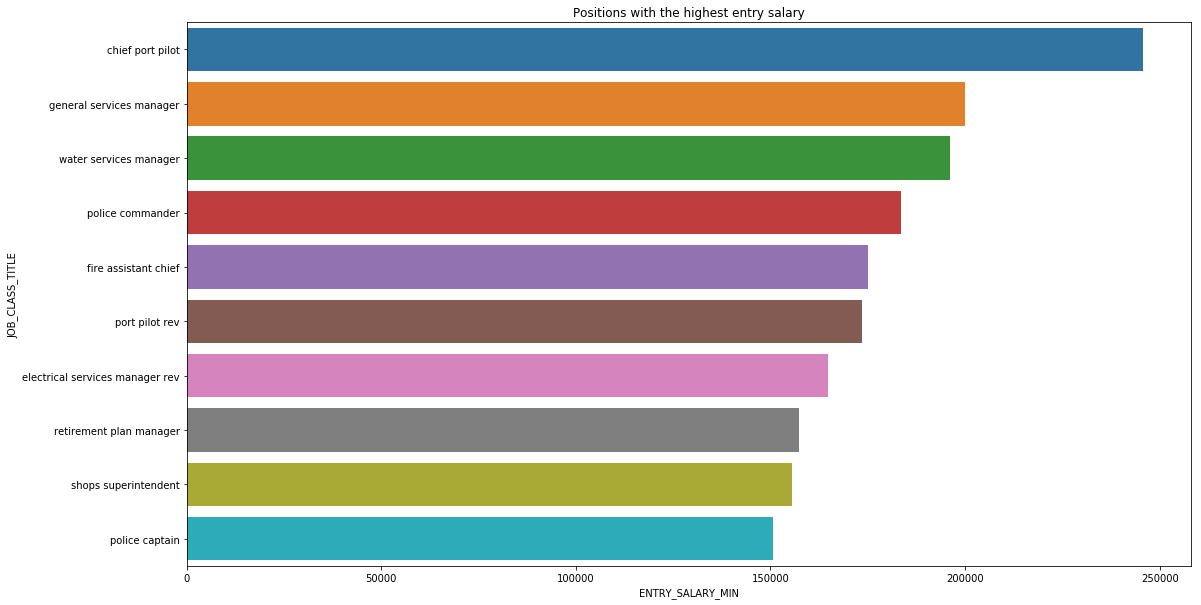

In [31]:

def plt_best_entry_salary(df):
    data = df
    data['ENTRY_SALARY_MIN'] = data['ENTRY_SALARY_MIN'].astype(int)
    data = df.sort_values(by='ENTRY_SALARY_MIN', ascending=False)
    plt.figure(figsize=(18, 10))
    plt.title('Positions with the highest entry salary')
    sns.barplot(y='JOB_CLASS_TITLE', x='ENTRY_SALARY_MIN', data=data.head(10))
    plt.show()

plt_best_entry_salary(df_jb)


Plot position with highest salary range


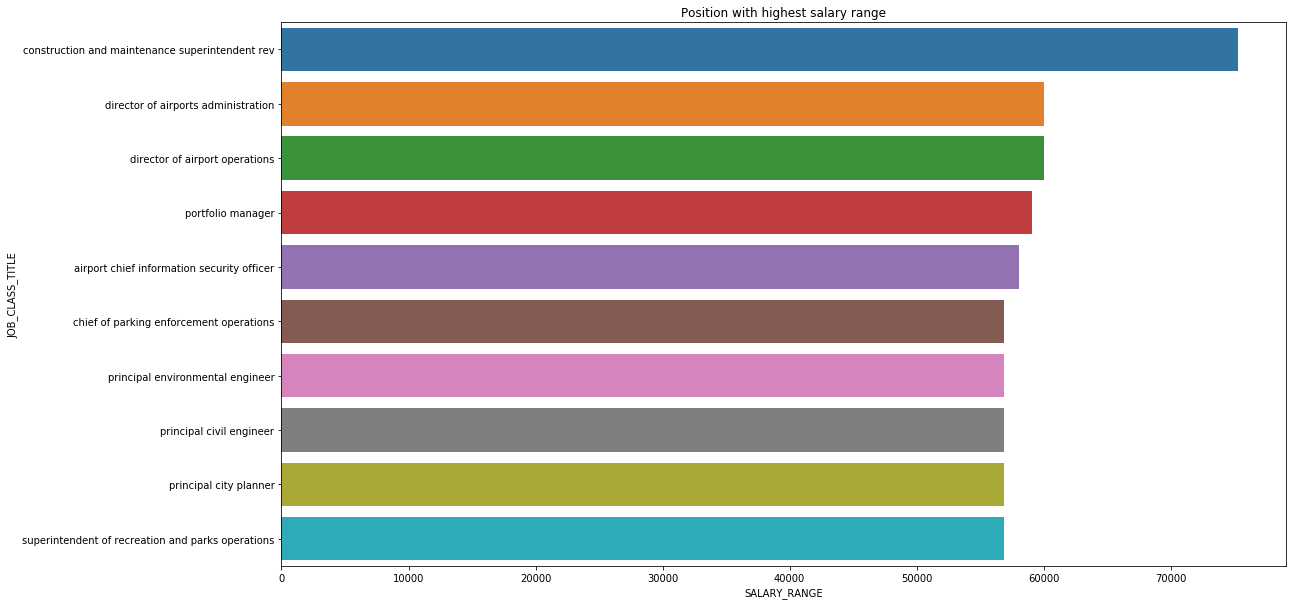

In [47]:

def plt_salary_range(df):
    data = df
    data['ENTRY_SALARY_MIN'] = data['ENTRY_SALARY_MIN'].astype(int)
    data['ENTRY_SALARY_MAX'] = data['ENTRY_SALARY_MAX'].astype(int)
    data['SALARY_RANGE'] = (data['ENTRY_SALARY_MAX']) - (data['ENTRY_SALARY_MIN'])
    data = data.sort_values(by='SALARY_RANGE', ascending=False)
    plt.figure(figsize=(18,10))
    plt.title('Position with highest salary range')
    sns.barplot(y='JOB_CLASS_TITLE', x='SALARY_RANGE', data=data.head(10))
    plt.show()

plt_salary_range(df_jb)
    

Wordcloud for position


In [229]:


def plt_wordcloud(df, feature):
    
    text = ' '.join(sum(df[feature].apply(word_tokenize), []))
    stopwords = set(STOPWORDS)
    stopwords.update(('supervisor', 'senior', 'chief', 'assistant', 'manager', 'years', 'year', 'Not Available'))
    wordcloud = WordCloud(stopwords=stopwords).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    

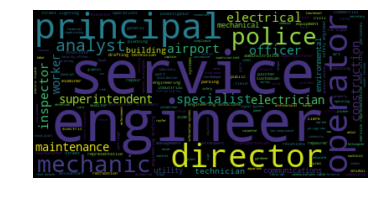

Wall time: 598 ms


In [200]:
%%time 

plt_wordcloud(df_jb, 'JOB_CLASS_TITLE')


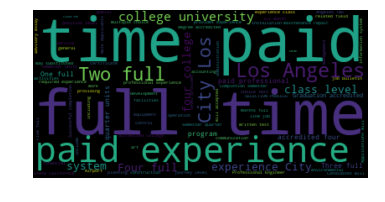

In [205]:
plt_wordcloud(df_jb, 'REQUIREMENT_SET_ID')


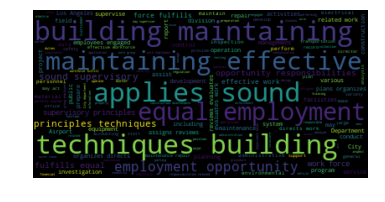

In [230]:
plt_wordcloud(df_jb, 'JOB_DUTIES')

* summary salaries
* highest range salaries




